# Loading polarization dataset and training a simple neural network

In this notebook, we show how to load our "processed" dataset, and give a simple example of how to use it to train a simple convolutionnal neural network that can predict the Sun's elevation based on a degree of polarization image. 

## Packages imports

In [1]:
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm

### Device for running code

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device="cpu"
print(f"Using {device} device")


Using cpu device


## Parameters

`data_dir` : Directory of the dataset \
`data_description_file` : File describing path to data folder and features for each measurement. In each folder, 11 numpy images can be loaded 

- image.npy, the raw pixel intensity image
- AOP_B.npy, the blue chanel processed angle of polarization
- AOP_Gb.npy, the green chanel (on the same rows as the blue chanel) processed angle of polarization
- AOP_Gr.npy, the green chanel (on the same rows as the red chanel) processed angle of polarization
- AOP_R.npy, the red chanel processed angle of polarization
- AOP_s.npy, the corresponding simulated image of the angle of polarization based on Rayleigh scattering model
- DOP_B.npy, the blue chanel processed degree of polarization
- DOP_Gb.npy, the green chanel (on the same rows as the blue chanel) processed degree of polarization
- DOP_Gr.npy, the green chanel (on the same rows as the red chanel) processed degree of polarization
- DOP_R.npy, the red chane processed degree of polarization
- DOP_s.npy, the corresponding simulated image of the degree of polarization based on Rayleigh scattering model 

`scale` : Dataset scale. 1 mean 100% of the dataset - set 0.1 (10%) for tests\
`batch_size` : batch size for data loader \
`num_epoch` : number of epoch for training \
`learning_rate` : learning rate for optimizer 

In [3]:
data_dir              = '/scratch/lpoughon/PolarizedDatabaseProcessed'
data_description_file = 'all_days.csv'

scale = 0.1
batch_size = 8
num_epoch = 10
learning_rate = 1e-3

## Load data 

### Data description display

In [4]:
pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = scale)

,Image_folder_path,Timestamp,Hour_Local,Minute_Local,Second_Local,Date,Sun_azimuth,Sun_zenith_angle,Sun_hour_angle,Sun_declination,Camera_exposure_time,Image_type
1925,2022-08-07/2022-08-07T12-40-16,2022-08-07T12-40-16,12,40,16,2022-08-07,148.167709,30.194046,-16.048426,73.644638,1512.904,0
8247,2022-08-05/2022-08-05T20-50-19,2022-08-05T20-50-19,20,50,19,2022-08-05,293.324896,89.912261,106.405917,73.185807,42326.000,1
200,2022-08-09/2022-08-09T11-40-24,2022-08-09T11-40-24,11,40,24,2022-08-09,126.573164,38.076862,-30.979151,74.202227,763.320,3
7169,2022-08-11/2022-08-11T20-30-31,2022-08-11T20-30-31,20,30,31,2022-08-11,288.856605,87.874774,101.619579,74.898383,92.632,6
236,2022-08-09/2022-08-09T12-50-33,2022-08-09T12-50-33,12,50,33,2022-08-09,153.189876,29.806619,-13.472731,74.216258,506.880,7
...,...,...,...,...,...,...,...,...,...,...,...,...
9221,2022-08-08/2022-08-08T17-40-31,2022-08-08T17-40-31,17,40,31,2022-08-08,260.449715,56.667870,59.001275,73.987038,92.632,6
1844,2022-08-07/2022-08-07T10-40-31,2022-08-07T10-40-31,10,40,31,2022-08-07,109.997483,47.304391,-46.043460,73.621354,92.632,6
4031,2022-07-31/2022-07-31T09-40-16,2022-07-31T09-40-16,9,40,16,2022-07-31,95.889452,56.797632,-61.204973,71.762057,2282.224,0
1990,2022-08-07/2022-08-07T14-30-32,2022-08-07T14-30-32,14,30,32,2022-08-07,203.427660,28.664490,11.463143,73.666123,92.632,6


### Create, load dataset and split it into train and test

In [5]:
class PolarizationDataset(Dataset):
    def __init__(self, data_dir, data_description_file, transform=None, target_transform=None):
        #sample(frac = scale, random_state=1) is used to sample the dataset in a reproducible way
        self.data_description_file = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = scale, random_state=1)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, idx):
        DoLP_exp = os.path.join(self.data_dir, self.data_description_file.iloc[idx, 0], 'DOP_B.npy')
        DoLP_simu = os.path.join(self.data_dir, self.data_description_file.iloc[idx, 0], 'DOP_s.npy')
        Sun_el = np.float32(90-self.data_description_file.iloc[idx, 7])
        
        ## DoLP data already normalized

        imageDoLP_exp = torch.from_numpy(np.load(DoLP_exp)).unsqueeze(0).float()
        imageDoLP_simu = torch.from_numpy(np.load(DoLP_simu)).unsqueeze(0).float()
        
        # replace Nan values to zero for easy calculation. 
        # This could be managed in a better way 

        imageDoLP_exp = torch.nan_to_num(imageDoLP_exp) 
        imageDoLP_simu = torch.nan_to_num(imageDoLP_simu)
        
        if self.transform:
            imageDoLP_exp = self.transform(imageDoLP_exp)
            imageDoLP_simu = self.transform(imageDoLP_simu)

        if self.target_transform:
            Sun_el = self.target_transform(Sun_el)
            
        
        return imageDoLP_exp, imageDoLP_simu, Sun_el
    
    def __len__(self):
        return len(self.data_description_file)
    

In [6]:
dataset = PolarizationDataset(data_dir, data_description_file)

#split data into train and te
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# generator : seed used to randomly split data into train and test set in a reproducible way
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1))

trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


### Display dataset

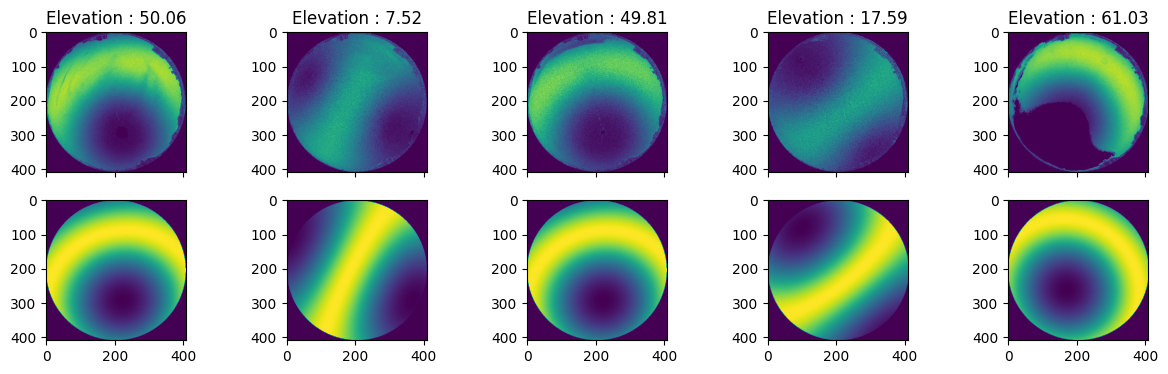

In [7]:
DoLP_exp_features, DoLP_simu_features, el_features = next(iter(trainloader))

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15,4))
for i in range(5):
    ax[0,i].imshow(DoLP_exp_features[i].squeeze())
    ax[1,i].imshow(DoLP_simu_features[i].squeeze())
    ax[0,i].set_title("Elevation : %.2f" % el_features[i].item())

## Load and train convolutional neural network for Sun elevation estimation

In [8]:
class CNNnetwork(nn.Module):
    def __init__(self):
        super(CNNnetwork, self).__init__()
        self.conv1 = nn.Conv2d(1,5, kernel_size=5)
        self.conv2 = nn.Conv2d(5,10, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(98010, 2000)
        self.fc2 = nn.Linear(2000,500)
        self.fc3 = nn.Linear(500,1)
    def forward(self,x):
        x = x.view(-1,1,409,409)
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
CNNnet = CNNnetwork()
CNNnet = CNNnet.to(device)
print(CNNnet)

CNNnetwork(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98010, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
)


In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, comp_device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    loop = tqdm(dataloader)
    for batch, (X,Xs,y) in enumerate(loop):
        # Compute prediction and loss
        X = X.to(comp_device)
        y = y.to(comp_device)
        
        #X.requires_grad_(True)
        #y.requires_grad_(True)
        
        pred = model(X).squeeze(1)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
        loop.set_description("Training")
        loop.set_postfix(loss=train_loss/(batch+1))
        #if batch % 10 == 0:
        #    lossp, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {lossp:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    return train_loss

def test_loop(dataloader, model, loss_fn,comp_device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        loop = tqdm(dataloader)
        for batch, (X,Xs,y) in enumerate(loop):
            X = X.to(comp_device)
            y = y.to(comp_device)
            
            pred = model(X).squeeze(1)
            loss = loss_fn(pred, y)
            
            test_loss+= loss.item()
            
            loop.set_description("Testing")
            loop.set_postfix(loss=test_loss/(batch+1))
    test_loss /= num_batches
    #print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

Epoch [1/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:20<00:00,  1.15it/s, loss=43.5]


Epoch [2/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.99it/s, loss=44.6]


Epoch [3/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.62it/s, loss=63.7]


Epoch [4/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.15it/s, loss=38.6]


Epoch [5/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.36it/s, loss=19.8]


Epoch [6/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.63it/s, loss=15.3]


Epoch [7/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.54it/s, loss=17.8]


Epoch [8/10]
-------------------------------


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.71it/s, loss=12]


Epoch [9/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.88it/s, loss=32.4]


Epoch [10/10]
-------------------------------


Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.78it/s, loss=11.3]

Done!


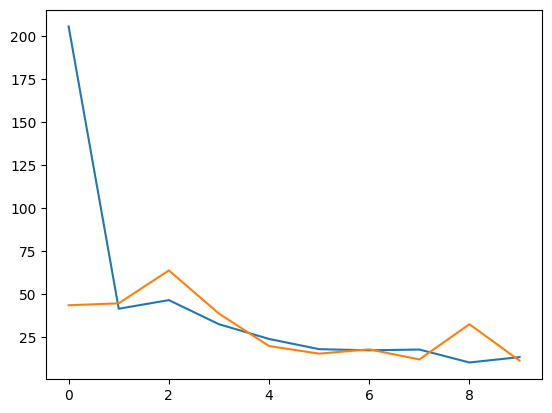

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=learning_rate)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_test_loss = 1_000_000.



train_loss_list = []
test_loss_list = []
for t in range(num_epoch):
    print(f"Epoch [{t+1}/{num_epoch}]\n-------------------------------")
    loss = train_loop(trainloader, CNNnet, criterion, optimizer, device)
    test_loss = test_loop(testloader, CNNnet, criterion, device)
    train_loss_list.append(loss)
    test_loss_list.append(test_loss)
    
    # Track best performance, and save the model's state
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        #denoising_model_path = 'Model_saved_parameters/CNNnet_{}_{}'.format(timestamp, epoch_number)
        #torch.save(CNNnet_.state_dict(), denoising_model_path)
    epoch_number += 1

print("Done!")
plt.plot(range(num_epoch),train_loss_list, range(num_epoch), test_loss_list)

### Display test set elevation estimation results

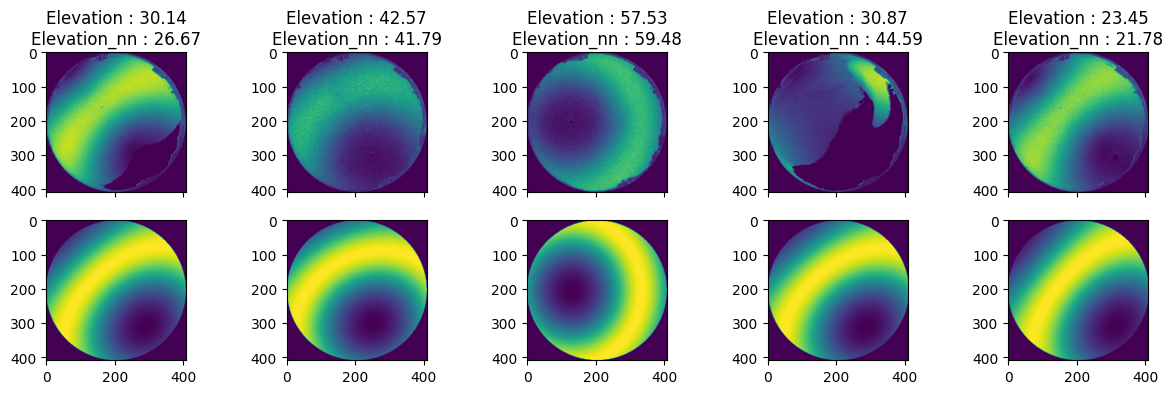

In [11]:
DoLP_exp_features, DoLP_simu_features, el_features = next(iter(testloader))
DoLP_exp_features = DoLP_exp_features.to(device)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15,4))
for i in range(5):
    ax[0,i].imshow(DoLP_exp_features[i].squeeze().cpu())
    ax[1,i].imshow(DoLP_simu_features[i].squeeze())
    ax[0,i].set_title("Elevation : {:.2f}\nElevation_nn : {:.2f}".format(el_features[i].item(), CNNnet(DoLP_exp_features)[i].item()))


In [12]:
DoLP_exp_features = DoLP_exp_features.to(device)
CNNnet.requires_grad = True
CNNnet(DoLP_exp_features)

tensor([[26.6721],
        [41.7924],
        [59.4754],
        [44.5898],
        [21.7776],
        [ 2.7903],
        [16.5416],
        [31.0229]], grad_fn=<AddmmBackward0>)

In [13]:
data_description_file_pd = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = scale, random_state=1)
DoLP_exp = os.path.join(data_dir, data_description_file_pd.iloc[1, 0], 'DOP_B.npy')


In [14]:
torch.Tensor(np.load(DoLP_exp)).shape

torch.Size([409, 409])